In [1]:
# import libraries and data


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import helper_functions as hf
data = pd.read_feather('2015_to_2024')









In [3]:
# define events:


y_event = '800'
x_event = 'Mile'


In [4]:
# get total row count and total athlete count 

print('rows: ',len(data))
print('athletes: ', len(data['athlete_id'].unique()))


print('average result count for athletes: ', len(data)/ len(data['athlete_id'].unique()))


rows:  11205190
athletes:  269849
average result count for athletes:  41.52392634399238


In [5]:
# get only y events (both genders)
y_events = data[(data['event']== y_event)]



In [6]:
# get a list of unique runners that comepted in the y event

y_event_athletes = y_events['athlete_id'].unique()

len(y_event_athletes)


86034

In [7]:
# get a data frame excluding all other athletes

only_y_event_athletes = data[data['athlete_id'].isin(y_event_athletes)]

In [8]:
# create a function to find those athlete ids that ran x1_event and x2_event
def did_x_event(events):
    has_x = events.str.contains(x_event, case=False, na=False).any()
    return has_x

In [10]:
# apply the funtion to identify who ran all events and who hasn't

have_3_events = only_y_event_athletes.groupby('athlete_id')['event'].apply(did_x_event)
filtered = have_3_events[have_3_events == True].index

filtered

Index(['01_).AG(-LEUNAMME_DRYBYLIME', '01_).AG(-LEUNAMME_LLIHYBBAG',
       '01_).AG(-LEUNAMME_THGIRWCAZ', '01_).ALF(-IMAIM_SENOJHSOJ',
       '01_).AP(-AINROFILAC_AZZEPKCIN', '01_).AP(-AINROFILAC_EBOJNOSAM',
       '01_).AP(-AINROFILAC_ECNAVARAS', '01_).AP(-AINROFILAC_ONAILUEOJ',
       '01_).AP(-ANAIDNI_HTIEKNYWG', '01_).AP(-ANAIDNI_SEMAJIROT',
       ...
       '9_YTIC-EVORG_ELYLALLE', '9_YTIC-EVORG_WORCYLIL',
       '9_YTIC-SASNAK_ETIHWIAK', '9_YTIC-SASNAK_NAYRYLLA',
       '9_YTIC-YESREJ-WEN_AHASUPOT', '9_YTISREVINU-NOTSOB_DRAWEKIM',
       '9_YTRAM-TNUOM_TGIOVMAS', '9_YTREBIL_NAODKCIN', '9_YTREBIL_RRACEPOH',
       '9_YVAN_TOOZEKAT'],
      dtype='object', name='athlete_id', length=48613)

In [11]:
# get only those that ran all the selected events and put them in a new dataframe (sample)


sample = only_y_event_athletes[only_y_event_athletes['athlete_id'].isin(filtered)][['athlete_id','event','performance','granular_performance','parsed_date','meet_type','place','gender','athlete_url','athlete_name','division']]

print('# of athletes avaialable for analysis: ',len(sample['athlete_id'].unique()))

# of athletes avaialable for analysis:  48613


In [51]:
# Get the fastest performance per athlete per event, gets fastest performance for all events for these athletes
# Step 0: Extract year from parsed_date
sample['year'] = pd.to_datetime(sample['parsed_date']).dt.year

event_data = sample[sample['event'].isin([x_event, y_event])]

# Step 1: Get fastest time per athlete per year per event
season_prs = (
    event_data
    .sort_values('granular_performance')  # Fastest first
    .groupby(['athlete_id', 'year', 'event'], as_index=False)
    .first()
)

#prs.head(10)

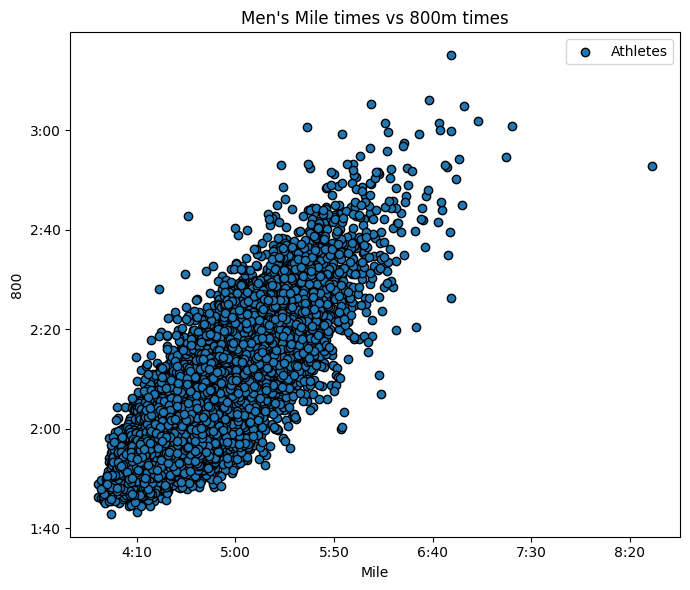

In [141]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import linregress

# Set the gender 
gender = 'M'  # 'M' or 'F'

if gender == 'M':
    gender_name = "Men's"
elif gender == 'F':
    gender_name = "Women's"
else:
    gender_name = 'overall'

# Step 4: Pivot to one row per athlete-year with both events (drop any that don't have both)
performance_matrix = (
    season_prs[season_prs['gender'] == gender]
    .pivot(index=['athlete_id', 'year'], columns='event', values='granular_performance')
    [[x_event, y_event]]  # Keep only those two events
    .dropna()  # Drop rows missing one of the events
)



# Formatter for axis labels
def simple_time_string(seconds):
    seconds = int(round(seconds))
    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    if hours:
        return f"{hours}:{minutes:02}:{sec:02}"
    else:
        return f"{minutes}:{sec:02}"

# More precise formatter for predicted label
def seconds_to_time_string(seconds):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    ms = int((seconds - int(seconds)) * 100)
    return f"{minutes:02d}:{sec:02d}.{ms:02d}"

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

x = performance_matrix[x_event]
y = performance_matrix[y_event]

# Scatter plot with slight opacity
ax.scatter(x, y, alpha=1.0, edgecolor='k', label='Athletes')


# Axis formatting
ax.set_title(f'{gender_name} Mile times vs 800m times')
ax.set_xlabel(x_event)
ax.set_ylabel(y_event)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: simple_time_string(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: simple_time_string(y)))

# Show legend
ax.legend()

plt.tight_layout()
plt.show()

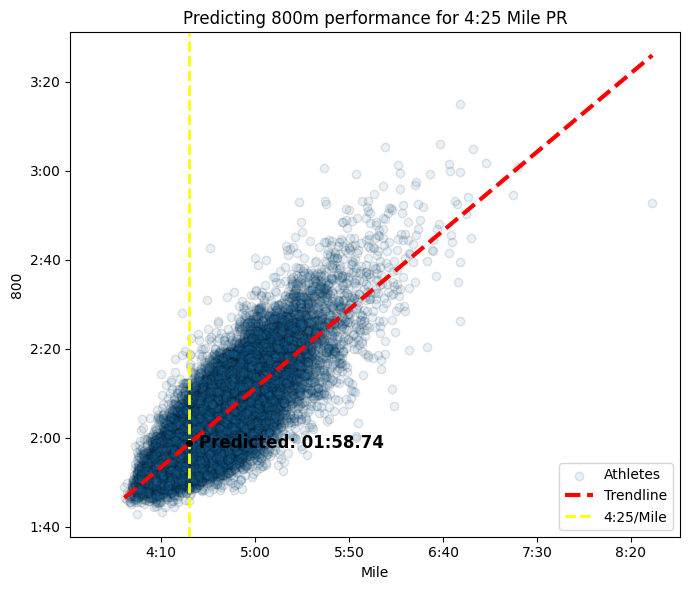

In [142]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import linregress

# Set the gender 
gender = 'M'  # 'M' or 'F'

# Step 4: Pivot to one row per athlete-year with both events (drop any that don't have both)
performance_matrix = (
    season_prs[season_prs['gender'] == gender]
    .pivot(index=['athlete_id', 'year'], columns='event', values='granular_performance')
    [[x_event, y_event]]  # Keep only those two events
    .dropna()  # Drop rows missing one of the events
)
'''
# Control for outliers
y_upper_percentile = 99  # keep x% fastest
x_upper_percentile = 99

performance_matrix = performance_matrix[
    (performance_matrix[x_event] <= performance_matrix[x_event].quantile(x_upper_percentile / 100)) &
    (performance_matrix[y_event] <= performance_matrix[y_event].quantile(y_upper_percentile / 100)) 
]
'''
# Formatter for axis labels
def simple_time_string(seconds):
    seconds = int(round(seconds))
    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    if hours:
        return f"{hours}:{minutes:02}:{sec:02}"
    else:
        return f"{minutes}:{sec:02}"

# More precise formatter for predicted label
def seconds_to_time_string(seconds):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    ms = int((seconds - int(seconds)) * 100)
    return f"{minutes:02d}:{sec:02d}.{ms:02d}"

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

x = performance_matrix[x_event]
y = performance_matrix[y_event]

# Scatter plot with slight opacity
ax.scatter(x, y, alpha=0.1, edgecolor='k', label='Athletes')

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = intercept + slope * x_vals

# Residuals and residual standard deviation for confidence band
residuals = y - (slope * x + intercept)
residual_std = np.std(residuals)

ci_multiplier = 0.67  # approx 50% prediction interval
y_upper = y_vals + ci_multiplier * residual_std
y_lower = y_vals - ci_multiplier * residual_std

# Plot trendline
ax.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=3, label='Trendline')

# Plot 50% confidence band as red translucent fill
#ax.fill_between(x_vals, y_lower, y_upper, color='red', alpha=0.2, label='~50% Confidence Band')

# Yellow vertical line at 265 seconds (no shadow)
ax.axvline(265, color='yellow', linestyle='--', linewidth=2, label = '4:25/Mile')

# Calculate prediction at x = 265
x_mile = 265
y_on_trend = slope * x_mile + intercept

# Horizontal orange line from left axis to x=265 intersection
ax.plot([ax.get_xlim()[0], x_mile], [y_on_trend, y_on_trend], color='black', linewidth=2.5, linestyle='-', alpha=0)

# Mark intersection point with dot
ax.plot(x_mile, y_on_trend, 'o', color='black', alpha=1,markersize = 4)

# Predicted time label near intersection
predicted_time_str = seconds_to_time_string(y_on_trend)
ax.text(
    x= x_mile + 5,
    y= y_on_trend,
    s=f'Predicted: {predicted_time_str}',
    color='black',
    fontsize=12,
    verticalalignment='center',
    fontweight='bold'
)

# Axis formatting
ax.set_title(f'Predicting 800m performance for 4:25 Mile PR')
ax.set_xlabel(x_event)
ax.set_ylabel(y_event)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: simple_time_string(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: simple_time_string(y)))

# Show legend
ax.legend()

plt.tight_layout()
plt.show()


In [114]:
# Calculate R²
r_squared = r_value ** 2
print(f"R²: {r_squared:.4f}")

R²: 0.5423


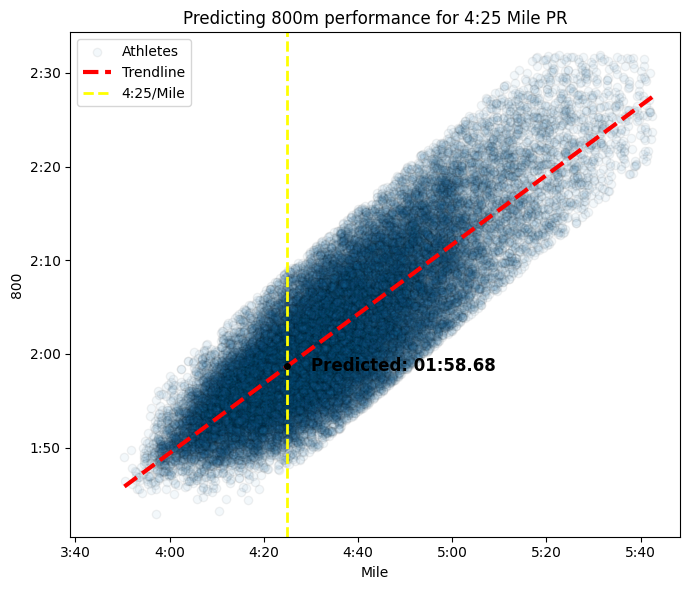

In [181]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import linregress

# Set the gender 
gender = 'M'  # 'M' or 'F'

# Step 4: Pivot to one row per athlete-year with both events (drop any that don't have both)
performance_matrix = (
    season_prs[season_prs['gender'] == gender]
    .pivot(index=['athlete_id', 'year'], columns='event', values='granular_performance')
    [[x_event, y_event]]  # Keep only those two events
    .dropna()  # Drop rows missing one of the events
)

# Control for outliers
y_upper_percentile = 99  # keep x% fastest
x_upper_percentile = 99

performance_matrix = performance_matrix[
    (performance_matrix[x_event] <= performance_matrix[x_event].quantile(x_upper_percentile / 100)) &
    (performance_matrix[y_event] <= performance_matrix[y_event].quantile(y_upper_percentile / 100)) 
]


# Step 1: Min-max normalize both columns to 0–1 scale
normalized = performance_matrix.copy()
normalized[x_event] = (performance_matrix[x_event] - performance_matrix[x_event].min()) / (performance_matrix[x_event].max() - performance_matrix[x_event].min())
normalized[y_event] = (performance_matrix[y_event] - performance_matrix[y_event].min()) / (performance_matrix[y_event].max() - performance_matrix[y_event].min())

# Step 2: Compute absolute difference in normalized values
normalized['norm_diff'] = (normalized[x_event] - normalized[y_event]).abs()

# Step 3: Exclude top 1% with largest difference
cutoff = normalized['norm_diff'].quantile(0.95)
filtered = normalized[normalized['norm_diff'] <= cutoff]

# Final filtered performance matrix (un-normalized times)
performance_matrix = performance_matrix.loc[filtered.index]



# Formatter for axis labels
def simple_time_string(seconds):
    seconds = int(round(seconds))
    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    if hours:
        return f"{hours}:{minutes:02}:{sec:02}"
    else:
        return f"{minutes}:{sec:02}"

# More precise formatter for predicted label
def seconds_to_time_string(seconds):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    ms = int((seconds - int(seconds)) * 100)
    return f"{minutes:02d}:{sec:02d}.{ms:02d}"

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

x = performance_matrix[x_event]
y = performance_matrix[y_event]

# Scatter plot with slight opacity
ax.scatter(x, y, alpha=0.05, edgecolor='k', label='Athletes')

# Linear regression
slope, intercept, r_value2, p_value, std_err = linregress(x, y)

x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = intercept + slope * x_vals

# Residuals and residual standard deviation for confidence band
residuals = y - (slope * x + intercept)
residual_std = np.std(residuals)

ci_multiplier = 0.67  # approx 50% prediction interval
y_upper = y_vals + ci_multiplier * residual_std
y_lower = y_vals - ci_multiplier * residual_std

# Plot trendline
ax.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=3, label='Trendline')

# Plot 50% confidence band as red translucent fill
#ax.fill_between(x_vals, y_lower, y_upper, color='red', alpha=0.2, label='~50% Confidence Band')

# Yellow vertical line at 265 seconds (no shadow)
ax.axvline(265, color='yellow', linestyle='--', linewidth=2, label = '4:25/Mile')

# Calculate prediction at x = 265
x_mile = 265
y_on_trend = slope * x_mile + intercept

# Horizontal orange line from left axis to x=265 intersection
ax.plot([ax.get_xlim()[0], x_mile], [y_on_trend, y_on_trend], color='black', linewidth=2.5, linestyle='-', alpha=0)

# Mark intersection point with dot
ax.plot(x_mile, y_on_trend, 'o', color='black', alpha=1,markersize = 4)

# Predicted time label near intersection
predicted_time_str = seconds_to_time_string(y_on_trend)
ax.text(
    x= x_mile + 5,
    y= y_on_trend,
    s=f'Predicted: {predicted_time_str}',
    color='black',
    fontsize=12,
    verticalalignment='center',
    fontweight='bold'
)

# Axis formatting
ax.set_title(f'Predicting 800m performance for 4:25 Mile PR')
ax.set_xlabel(x_event)
ax.set_ylabel(y_event)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: simple_time_string(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: simple_time_string(y)))

# Show legend
ax.legend()

plt.tight_layout()
plt.show()


In [178]:
# Calculate R²
r_squared = r_value2 ** 2
print(f"R²: {r_squared:.4f}")

R²: 0.7073


In [182]:
from scipy.stats import t

n = len(x)
alpha = 0.10  # for 90% prediction interval
t_val = t.ppf(1 - alpha/2, df=n - 2)

# Compute standard error of prediction at x = 265
x_mean = np.mean(x)
se_pred = residual_std * np.sqrt(1 + 1/n + ((x_mile - x_mean)**2 / np.sum((x - x_mean)**2)))

# Prediction interval bounds
y_pred_lower = y_on_trend - t_val * se_pred
y_pred_upper = y_on_trend + t_val * se_pred


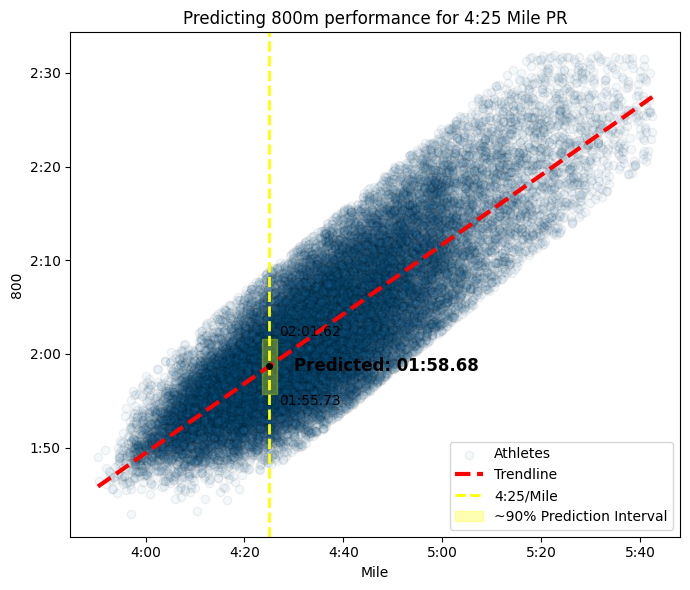

In [184]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import linregress, t

# Set the gender 
gender = 'M'  # 'M' or 'F'

# Step 4: Pivot to one row per athlete-year with both events (drop any that don't have both)
performance_matrix = (
    season_prs[season_prs['gender'] == gender]
    .pivot(index=['athlete_id', 'year'], columns='event', values='granular_performance')
    [[x_event, y_event]]  # Keep only those two events
    .dropna()  # Drop rows missing one of the events
)

# Control for outliers
y_upper_percentile = 99  # keep x% fastest
x_upper_percentile = 99

performance_matrix = performance_matrix[
    (performance_matrix[x_event] <= performance_matrix[x_event].quantile(x_upper_percentile / 100)) &
    (performance_matrix[y_event] <= performance_matrix[y_event].quantile(y_upper_percentile / 100)) 
]

# Step 1: Min-max normalize both columns to 0–1 scale
normalized = performance_matrix.copy()
normalized[x_event] = (performance_matrix[x_event] - performance_matrix[x_event].min()) / (performance_matrix[x_event].max() - performance_matrix[x_event].min())
normalized[y_event] = (performance_matrix[y_event] - performance_matrix[y_event].min()) / (performance_matrix[y_event].max() - performance_matrix[y_event].min())

# Step 2: Compute absolute difference in normalized values
normalized['norm_diff'] = (normalized[x_event] - normalized[y_event]).abs()

# Step 3: Exclude top 1% with largest difference
cutoff = normalized['norm_diff'].quantile(0.95)
filtered = normalized[normalized['norm_diff'] <= cutoff]

# Final filtered performance matrix (un-normalized times)
performance_matrix = performance_matrix.loc[filtered.index]

# Formatter for axis labels
def simple_time_string(seconds):
    seconds = int(round(seconds))
    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    if hours:
        return f"{hours}:{minutes:02}:{sec:02}"
    else:
        return f"{minutes}:{sec:02}"

# More precise formatter for predicted label
def seconds_to_time_string(seconds):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    ms = int((seconds - int(seconds)) * 100)
    return f"{minutes:02d}:{sec:02d}.{ms:02d}"

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

x = performance_matrix[x_event]
y = performance_matrix[y_event]

# Scatter plot with slight opacity
ax.scatter(x, y, alpha=0.05, edgecolor='k', label='Athletes')

# Linear regression
slope, intercept, r_value2, p_value, std_err = linregress(x, y)

x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = intercept + slope * x_vals

# Residuals and residual standard deviation for prediction interval
residuals = y - (slope * x + intercept)
residual_std = np.std(residuals)

# Plot trendline
ax.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=3, label='Trendline')

# Yellow vertical line at 265 seconds (no shadow)
x_mile = 265
ax.axvline(x_mile, color='yellow', linestyle='--', linewidth=2, label='4:25/Mile')

# Prediction at x = 265
y_on_trend = slope * x_mile + intercept

# Draw prediction point
ax.plot(x_mile, y_on_trend, 'o', color='black', alpha=1, markersize=4)

# --- 90% Prediction Interval Calculation ---
n = len(x)
alpha = 0.5  # for 90% prediction interval
t_val = t.ppf(1 - alpha / 2, df=n - 2)
x_mean = np.mean(x)
se_pred = residual_std * np.sqrt(1 + 1/n + ((x_mile - x_mean) ** 2) / np.sum((x - x_mean) ** 2))
y_pred_lower = y_on_trend - t_val * se_pred
y_pred_upper = y_on_trend + t_val * se_pred

# Yellow shadow box for 90% prediction interval
ax.fill_betweenx(
    [y_pred_lower, y_pred_upper],
    x_mile - 1.5, x_mile + 1.5,
    color='yellow',
    alpha=0.3,
    label='~90% Prediction Interval'
)

# Annotate prediction
predicted_time_str = seconds_to_time_string(y_on_trend)
ax.text(
    x=x_mile + 5,
    y=y_on_trend,
    s=f'Predicted: {predicted_time_str}',
    color='black',
    fontsize=12,
    verticalalignment='center',
    fontweight='bold'
)

# Annotate prediction bounds
ax.text(
    x_mile + 2,
    y_pred_upper,
    f'{seconds_to_time_string(y_pred_upper)}',
    color='black',
    fontsize=10,
    verticalalignment='bottom'
)
ax.text(
    x_mile + 2,
    y_pred_lower,
    f'{seconds_to_time_string(y_pred_lower)}',
    color='black',
    fontsize=10,
    verticalalignment='top'
)

# Axis formatting
ax.set_title(f'Predicting 800m performance for 4:25 Mile PR')
ax.set_xlabel(x_event)
ax.set_ylabel(y_event)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: simple_time_string(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: simple_time_string(y)))

# Show legend
ax.legend()

plt.tight_layout()
plt.show()


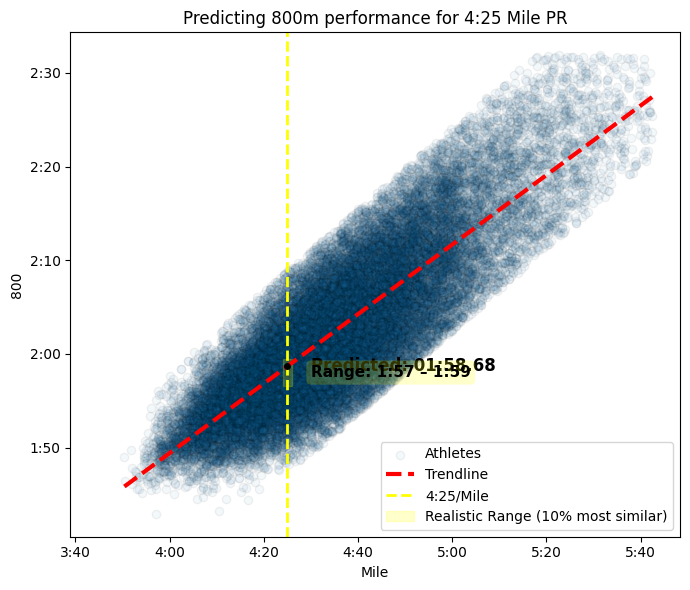

In [196]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import linregress

# Set the gender 
gender = 'M'  # 'M' or 'F'

# Step 4: Pivot to one row per athlete-year with both events (drop any that don't have both)
performance_matrix = (
    season_prs[season_prs['gender'] == gender]
    .pivot(index=['athlete_id', 'year'], columns='event', values='granular_performance')
    [[x_event, y_event]]  # Keep only those two events
    .dropna()  # Drop rows missing one of the events
)

# Control for outliers
y_upper_percentile = 99  # keep x% fastest
x_upper_percentile = 99

performance_matrix = performance_matrix[
    (performance_matrix[x_event] <= performance_matrix[x_event].quantile(x_upper_percentile / 100)) &
    (performance_matrix[y_event] <= performance_matrix[y_event].quantile(y_upper_percentile / 100)) 
]

# Step 1: Min-max normalize both columns to 0–1 scale
normalized = performance_matrix.copy()
normalized[x_event] = (performance_matrix[x_event] - performance_matrix[x_event].min()) / (performance_matrix[x_event].max() - performance_matrix[x_event].min())
normalized[y_event] = (performance_matrix[y_event] - performance_matrix[y_event].min()) / (performance_matrix[y_event].max() - performance_matrix[y_event].min())

# Step 2: Compute absolute difference in normalized values
normalized['norm_diff'] = (normalized[x_event] - normalized[y_event]).abs()

# Step 3: Exclude top 5% with largest difference
cutoff = normalized['norm_diff'].quantile(0.95)
filtered = normalized[normalized['norm_diff'] <= cutoff]

# Final filtered performance matrix (un-normalized times)
performance_matrix = performance_matrix.loc[filtered.index]

# Formatter for axis labels
def simple_time_string(seconds):
    seconds = int(round(seconds))
    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    if hours:
        return f"{hours}:{minutes:02}:{sec:02}"
    else:
        return f"{minutes}:{sec:02}"

# More precise formatter for predicted label
def seconds_to_time_string(seconds):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    ms = int((seconds - int(seconds)) * 100)
    return f"{minutes:02d}:{sec:02d}.{ms:02d}"

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

x = performance_matrix[x_event]
y = performance_matrix[y_event]

# Scatter plot with slight opacity
ax.scatter(x, y, alpha=0.05, edgecolor='k', label='Athletes')

# Linear regression
slope, intercept, r_value2, p_value, std_err = linregress(x, y)

x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = intercept + slope * x_vals

# Plot trendline
ax.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=3, label='Trendline')

# Yellow vertical line at 265 seconds (no shadow)
x_mile = 265
ax.axvline(x_mile, color='yellow', linestyle='--', linewidth=2, label='4:25/Mile')

# Calculate prediction at x = 265
y_on_trend = slope * x_mile + intercept

# Horizontal orange line from left axis to x=265 intersection
ax.plot([ax.get_xlim()[0], x_mile], [y_on_trend, y_on_trend], color='black', linewidth=2.5, linestyle='-', alpha=0)

# Mark intersection point with dot
ax.plot(x_mile, y_on_trend, 'o', color='black', alpha=1, markersize=4)

# Predicted time label near intersection
predicted_time_str = seconds_to_time_string(y_on_trend)
ax.text(
    x=x_mile + 5,
    y=y_on_trend,
    s=f'Predicted: {predicted_time_str}',
    color='black',
    fontsize=12,
    verticalalignment='center',
    fontweight='bold'
)

# -------- Realistic Range Band Based on Similar Athletes -------- #
# Step 1: Reuse the normalized difference to identify similar athletes
top_10_percent = normalized.nsmallest(int(0.10 * len(normalized)), 'norm_diff')
subset_ids = top_10_percent.index

# Step 2: Filter those athletes within ±2 sec of x_mile
subset_close_to_265 = performance_matrix.loc[subset_ids]
subset_close_to_265 = subset_close_to_265[
    (subset_close_to_265[x_event] >= x_mile - 2) &
    (subset_close_to_265[x_event] <= x_mile + 2)
]

# Step 3: Get their 800m times and compute realistic range
if not subset_close_to_265.empty:
    realistic_min = subset_close_to_265[y_event].min()
    realistic_max = subset_close_to_265[y_event].max()

    # Plot yellow shaded region as "realistic prediction band"
    ax.fill_between(
        [x_mile - 1, x_mile + 1],  # small horizontal span
        [realistic_min, realistic_min],
        [realistic_max, realistic_max],
        color='yellow',
        alpha=0.2,
        label='Realistic Range (10% most similar)'
    )

    # Annotate the range
    ax.text(
        x_mile + 5,
        (realistic_min + realistic_max) / 2,
        f"Range: {simple_time_string(realistic_min)} – {simple_time_string(realistic_max)}",
        color='black',
        fontsize=11,
        fontweight='bold',
        verticalalignment='center',
        bbox=dict(facecolor='yellow', alpha=0.2, edgecolor='none', boxstyle='round,pad=0.3')
    )

# --------------------------------------------------------------- #

# Axis formatting
ax.set_title(f'Predicting 800m performance for 4:25 Mile PR')
ax.set_xlabel(x_event)
ax.set_ylabel(y_event)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: simple_time_string(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: simple_time_string(y)))

# Show legend
ax.legend()

plt.tight_layout()
plt.show()


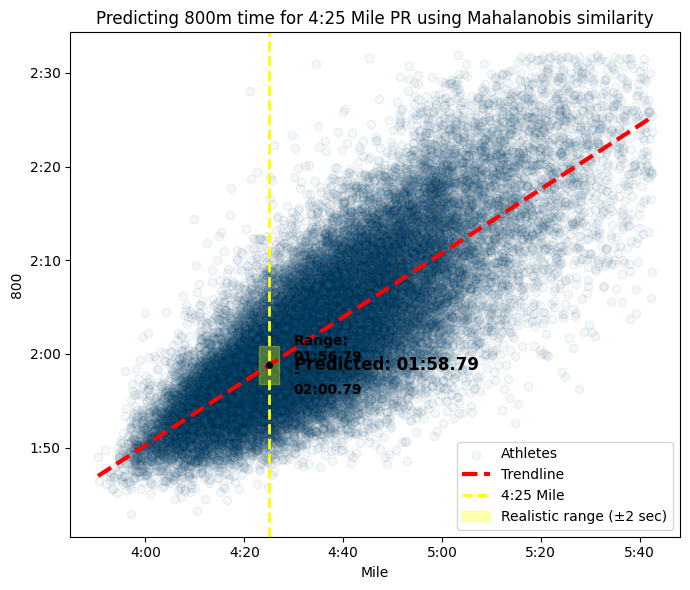

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import linregress
from scipy.spatial import distance

# Set the gender 
gender = 'M'  # 'M' or 'F'

# Step 4: Pivot to one row per athlete-year with both events (drop any that don't have both)
performance_matrix = (
    season_prs[season_prs['gender'] == gender]
    .pivot(index=['athlete_id', 'year'], columns='event', values='granular_performance')
    [[x_event, y_event]]  # Keep only those two events
    .dropna()  # Drop rows missing one of the events
)

# Control for outliers (keep 99th percentile fastest times)
y_upper_percentile = 99
x_upper_percentile = 99
performance_matrix = performance_matrix[
    (performance_matrix[x_event] <= performance_matrix[x_event].quantile(x_upper_percentile / 100)) &
    (performance_matrix[y_event] <= performance_matrix[y_event].quantile(y_upper_percentile / 100)) 
]

# Formatter for axis labels
def simple_time_string(seconds):
    seconds = int(round(seconds))
    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    if hours:
        return f"{hours}:{minutes:02}:{sec:02}"
    else:
        return f"{minutes}:{sec:02}"

# More precise formatter for predicted label
def seconds_to_time_string(seconds):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    ms = int((seconds - int(seconds)) * 100)
    return f"{minutes:02d}:{sec:02d}.{ms:02d}"

# Linear regression on the full dataset
x = performance_matrix[x_event]
y = performance_matrix[y_event]
slope, intercept, r_value2, p_value, std_err = linregress(x, y)

# Predicted 800m for the target mile time
x_mile = 265
y_pred = slope * x_mile + intercept

# Compute Mahalanobis distance to filter similar athletes
X = performance_matrix[[x_event, y_event]].values
mean_vec = np.mean(X, axis=0)
cov_matrix = np.cov(X, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
target_point = np.array([x_mile, y_pred])

# Calculate Mahalanobis distances
mahal_distances = np.array([distance.mahalanobis(row, target_point, inv_cov_matrix) for row in X])

# Select the 10% closest points by Mahalanobis distance
threshold = np.percentile(mahal_distances, 10)
similar_mask = mahal_distances <= threshold
similar_athletes = performance_matrix.iloc[similar_mask]

# Get realistic range: ±2 seconds around predicted 800m time, clipped to similar athletes' times
lower_bound = max(y_pred - 2, similar_athletes[y_event].min())
upper_bound = min(y_pred + 2, similar_athletes[y_event].max())

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

# Scatter plot of all athletes with low opacity
ax.scatter(x, y, alpha=0.05, edgecolor='k', label='Athletes')

# Plot trendline
x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = intercept + slope * x_vals
ax.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=3, label='Trendline')

# Vertical yellow line at the mile time of interest
ax.axvline(x_mile, color='yellow', linestyle='--', linewidth=2, label='4:25 Mile')

# Mark intersection point of prediction
ax.plot(x_mile, y_pred, 'o', color='black', alpha=1, markersize=4)

# Predicted time label
predicted_time_str = seconds_to_time_string(y_pred)
ax.text(
    x=x_mile + 5,
    y=y_pred,
    s=f'Predicted: {predicted_time_str}',
    color='black',
    fontsize=12,
    verticalalignment='center',
    fontweight='bold'
)

# Yellow shadow box for ±2 sec range over similar athletes' times
ax.fill_betweenx(
    y=[lower_bound, upper_bound],
    x1=x_mile - 2,
    x2=x_mile + 2,
    color='yellow',
    alpha=0.3,
    label='Realistic range (±2 sec)'
)

# Text for realistic range on plot
ax.text(
    x=x_mile + 5,
    y=(lower_bound + upper_bound) / 2,
    s=f'Range:\n{seconds_to_time_string(lower_bound)}\n-\n{seconds_to_time_string(upper_bound)}',
    color='black',
    fontsize=10,
    verticalalignment='center',
    fontweight='bold'
)

# Axis formatting
ax.set_title('Predicting 800m time for 4:25 Mile PR using Mahalanobis similarity')
ax.set_xlabel(x_event)
ax.set_ylabel(y_event)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: simple_time_string(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: simple_time_string(y)))

ax.legend()
plt.tight_layout()
plt.show()


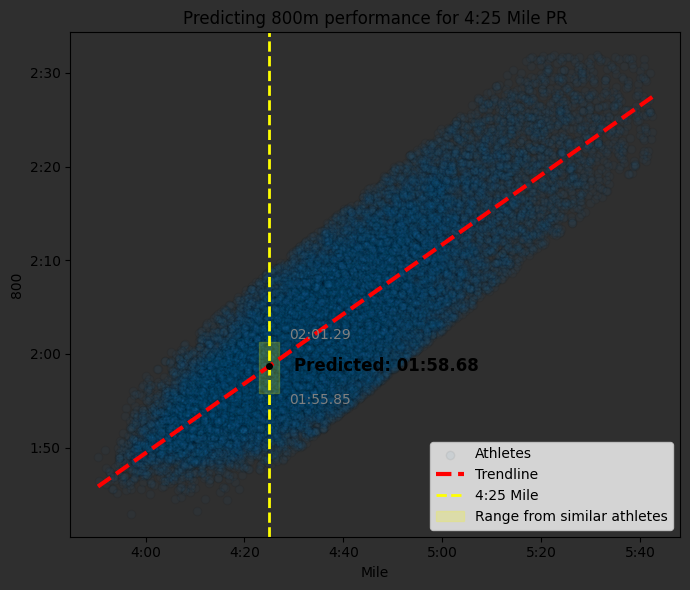

In [208]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.spatial import distance

# Set the gender
gender = 'M'

# Step 1: Filter and pivot data
performance_matrix = (
    season_prs[season_prs['gender'] == gender]
    .pivot(index=['athlete_id', 'year'], columns='event', values='granular_performance')
    [[x_event, y_event]]
    .dropna()
)

# Step 2: Remove outliers
x_upper_percentile = 99
y_upper_percentile = 99

performance_matrix = performance_matrix[
    (performance_matrix[x_event] <= performance_matrix[x_event].quantile(x_upper_percentile / 100)) &
    (performance_matrix[y_event] <= performance_matrix[y_event].quantile(y_upper_percentile / 100))
]



# Step 1: Min-max normalize both columns to 0–1 scale
normalized = performance_matrix.copy()
normalized[x_event] = (performance_matrix[x_event] - performance_matrix[x_event].min()) / (performance_matrix[x_event].max() - performance_matrix[x_event].min())
normalized[y_event] = (performance_matrix[y_event] - performance_matrix[y_event].min()) / (performance_matrix[y_event].max() - performance_matrix[y_event].min())

# Step 2: Compute absolute difference in normalized values
normalized['norm_diff'] = (normalized[x_event] - normalized[y_event]).abs()

# Step 3: Exclude top 5% with largest difference
cutoff = normalized['norm_diff'].quantile(0.95)
filtered = normalized[normalized['norm_diff'] <= cutoff]

# Final filtered performance matrix (un-normalized times)
performance_matrix = performance_matrix.loc[filtered.index]

# Step 3: Normalize for Mahalanobis
normalized = performance_matrix.copy()
normalized[x_event] = (performance_matrix[x_event] - performance_matrix[x_event].mean()) / performance_matrix[x_event].std()
normalized[y_event] = (performance_matrix[y_event] - performance_matrix[y_event].mean()) / performance_matrix[y_event].std()

# Compute Mahalanobis distances to the target point (normalized)
target_x = 265
target_normalized_x = (target_x - performance_matrix[x_event].mean()) / performance_matrix[x_event].std()
target_vector = np.array([target_normalized_x, np.nan])  # y is unknown

# Fill in full target vector using regression
slope, intercept, r_value2, p_value, std_err = linregress(performance_matrix[x_event], performance_matrix[y_event])
predicted_y = slope * target_x + intercept
target_normalized_y = (predicted_y - performance_matrix[y_event].mean()) / performance_matrix[y_event].std()
target_vector[1] = target_normalized_y

# Mahalanobis distance computation
X = normalized[[x_event, y_event]].values
VI = np.linalg.inv(np.cov(X, rowvar=False))
dists = np.array([distance.mahalanobis(row, target_vector, VI) for row in X])

# Add distances to DataFrame
performance_matrix['mahal_dist'] = dists

# Step 4: Keep top 10% closest by Mahalanobis distance
top_10_percent = performance_matrix.nsmallest(int(0.10 * len(performance_matrix)), 'mahal_dist')

# Compute range of their actual y_event (800m) times
lower_bound = top_10_percent[y_event].quantile(0.05)
upper_bound = top_10_percent[y_event].quantile(0.95)

# Formatter helpers
def simple_time_string(seconds):
    seconds = int(round(seconds))
    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{hours}:{minutes:02}:{sec:02}" if hours else f"{minutes}:{sec:02}"

def seconds_to_time_string(seconds):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    ms = int((seconds - int(seconds)) * 100)
    return f"{minutes:02d}:{sec:02d}.{ms:02d}"

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

x = performance_matrix[x_event]
y = performance_matrix[y_event]

ax.scatter(x, y, alpha=0.05, edgecolor='k', label='Athletes')

# Trendline
x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = intercept + slope * x_vals
ax.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=3, label='Trendline')

# Vertical line at 265s
ax.axvline(265, color='yellow', linestyle='--', linewidth=2, label='4:25 Mile')

# Predicted point
ax.plot(265, predicted_y, 'o', color='black', markersize=4)
ax.text(
    x=265 + 5,
    y=predicted_y,
    s=f'Predicted: {seconds_to_time_string(predicted_y)}',
    color='black',
    fontsize=12,
    verticalalignment='center',
    fontweight='bold'
)

# Draw shaded prediction range (realistic band from similar runners)
ax.fill_betweenx(
    [lower_bound, upper_bound],
    265 - 2, 265 + 2,
    color='yellow',
    alpha=0.2,
    label='Range from similar athletes'
)

# Annotate range values
ax.text(
    x=265 + 4,
    y=upper_bound,
    s=f'{seconds_to_time_string(upper_bound)}',
    fontsize=10,
    color='gray',
    verticalalignment='bottom'
)
ax.text(
    x=265 + 4,
    y=lower_bound,
    s=f'{seconds_to_time_string(lower_bound)}',
    fontsize=10,
    color='gray',
    verticalalignment='top'
)

# Axes formatting
ax.set_title(f'Predicting 800m performance for 4:25 Mile PR')
ax.set_xlabel(x_event)
ax.set_ylabel(y_event)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: simple_time_string(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: simple_time_string(y)))

ax.legend()
plt.tight_layout()

fig.patch.set_facecolor('#2f2f2f')   # Dark grey figure background
ax.set_facecolor('#2f2f2f')          # Dark grey axes background
plt.show()


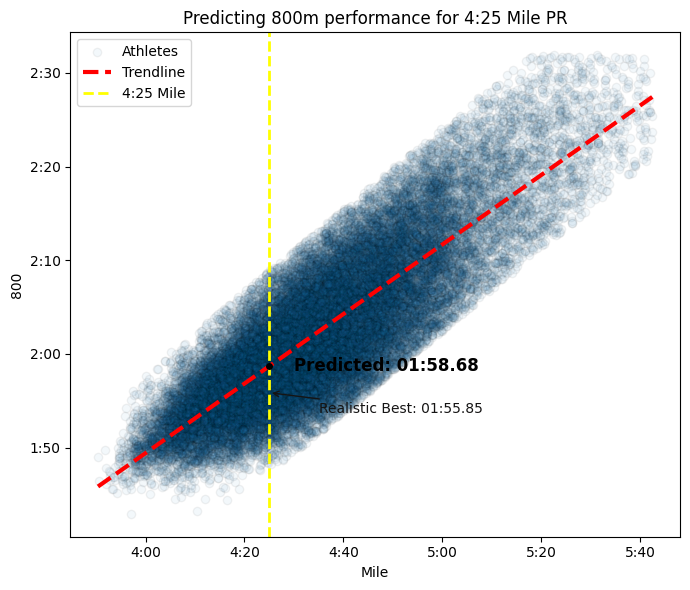

In [217]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.spatial import distance

# Set gender
gender = 'M'

# Step 1: Filter and pivot data
performance_matrix = (
    season_prs[season_prs['gender'] == gender]
    .pivot(index=['athlete_id', 'year'], columns='event', values='granular_performance')
    [[x_event, y_event]]
    .dropna()
)

# Step 2: Remove outliers
x_upper_percentile = 99
y_upper_percentile = 99

performance_matrix = performance_matrix[
    (performance_matrix[x_event] <= performance_matrix[x_event].quantile(x_upper_percentile / 100)) &
    (performance_matrix[y_event] <= performance_matrix[y_event].quantile(y_upper_percentile / 100))
]

# Step 3a: Pre-filter data where x and y are reasonably consistent
normalized = performance_matrix.copy()
normalized[x_event] = (performance_matrix[x_event] - performance_matrix[x_event].min()) / (performance_matrix[x_event].max() - performance_matrix[x_event].min())
normalized[y_event] = (performance_matrix[y_event] - performance_matrix[y_event].min()) / (performance_matrix[y_event].max() - performance_matrix[y_event].min())

normalized['norm_diff'] = (normalized[x_event] - normalized[y_event]).abs()
cutoff = normalized['norm_diff'].quantile(0.95)
filtered = normalized[normalized['norm_diff'] <= cutoff]
performance_matrix = performance_matrix.loc[filtered.index]

# Step 3b: Normalize for Mahalanobis
normalized = performance_matrix.copy()
normalized[x_event] = (performance_matrix[x_event] - performance_matrix[x_event].mean()) / performance_matrix[x_event].std()
normalized[y_event] = (performance_matrix[y_event] - performance_matrix[y_event].mean()) / performance_matrix[y_event].std()

# Predict 800m time using regression
target_x = 265  # mile time in seconds
slope, intercept, r_value2, p_value, std_err = linregress(performance_matrix[x_event], performance_matrix[y_event])
predicted_y = slope * target_x + intercept

# Mahalanobis distance to regression-predicted point
target_normalized_x = (target_x - performance_matrix[x_event].mean()) / performance_matrix[x_event].std()
target_normalized_y = (predicted_y - performance_matrix[y_event].mean()) / performance_matrix[y_event].std()
target_vector = np.array([target_normalized_x, target_normalized_y])

X = normalized[[x_event, y_event]].values
VI = np.linalg.inv(np.cov(X, rowvar=False))
dists = np.array([distance.mahalanobis(row, target_vector, VI) for row in X])
performance_matrix['mahal_dist'] = dists

# Keep top 10% most similar athletes
top_10_percent = performance_matrix.nsmallest(int(0.10 * len(performance_matrix)), 'mahal_dist')

# Compute best-case time (5th percentile)
best_case_time = top_10_percent[y_event].quantile(0.05)

# Helper functions
def simple_time_string(seconds):
    seconds = int(round(seconds))
    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{hours}:{minutes:02}:{sec:02}" if hours else f"{minutes}:{sec:02}"

def seconds_to_time_string(seconds):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    ms = int((seconds - int(seconds)) * 100)
    return f"{minutes:02d}:{sec:02d}.{ms:02d}"

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

x = performance_matrix[x_event]
y = performance_matrix[y_event]

ax.scatter(x, y, alpha=0.05, edgecolor='k', label='Athletes')

# Trendline
x_vals = np.linspace(x.min(), x.max(), 300)
y_vals = intercept + slope * x_vals
ax.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=3, label='Trendline')

# Vertical line at 265s
ax.axvline(265, color='yellow', linestyle='--', linewidth=2, label='4:25 Mile')

# Predicted point
ax.plot(265, predicted_y, 'o', color='black', markersize=4)
ax.text(
    x=265 + 5,
    y=predicted_y,
    s=f'Predicted: {seconds_to_time_string(predicted_y)}',
    color='black',
    fontsize=12,
    verticalalignment='center',
    fontweight='bold'
)

# Annotate best-case scenario
ax.annotate(
    f'Realistic Best: {seconds_to_time_string(best_case_time)}',
    xy=(265, best_case_time),
    xytext=(265 + 10, best_case_time - 1),
    arrowprops=dict(arrowstyle="->", color="#151414"),
    fontsize=10,
    color='#151414',
    verticalalignment='top'
)

# Axes formatting
ax.set_title(f'Predicting 800m performance for 4:25 Mile PR')
ax.set_xlabel(x_event)
ax.set_ylabel(y_event)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: simple_time_string(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: simple_time_string(y)))

ax.legend()
plt.tight_layout()

plt.show()
